In [1]:
import cv2
# Standard packages
from skimage import morphology

import numpy as np
import pandas as pd
import cv2

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import SimpleITK as sitk
import porespy as ps
from radiomics import featureextractor, shape, firstorder, glcm, glrlm

from collections import Counter

from multiprocessing import Pool

# Custom packages
import auxiliary.values as v
from filtering import cardiac_region as cr
from auxiliary.data.dataset_ht import HtDataset
from auxiliary.utils.colors import bcolors as c
from auxiliary.data import imaging

In [2]:
specimen = '0806_E6'
tissue = 'myocardium'

ds = HtDataset()
path_nu_feat = ds.read_features(specimen, 'Nuclei', tissue)
path_mem_feat = ds.read_features(specimen, 'Membrane', tissue)

path_nu_img, _ = ds.read_specimen(specimen, 'Nuclei', 'Segmentation', verbose=1)
path_mem_img, _ = ds.read_specimen(specimen, 'Membrane', 'Segmentation', verbose=1)
path_lines, _ = ds.read_line(specimen, verbose=1)

lines = imaging.read_image(path_lines, verbose=1)
nuclei = imaging.read_image(path_nu_img, verbose=1)
nuclei = cr.filter_by_tissue(nuclei, lines, tissue, dilate=1, verbose=1)

membrane = imaging.read_image(path_mem_img, verbose=1)
membrane = cr.filter_by_tissue(membrane, lines, tissue, dilate=1, verbose=1)

feat_nu = pd.read_csv(path_nu_feat)
feat_mem = pd.read_csv(path_mem_feat)

print(len(feat_nu), len(feat_mem))

	Found: 20190806_E6_nuclei_mask_None.nii.gz
	Found: 20190806_E6_mGFP_XYZ_predictions_GASP.nii.gz
	Found: line_20190806_E6.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/Segmentation/LinesTissue/line_20190806_E6.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/Segmentation/Nuclei/20190806_E6_nuclei_mask_None.nii.gz
Filtering image by tissue: myocardium...
Dilating mask: (3x3) 1 times...
[==================================================] 100.00%
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/Segmentation/Membrane/20190806_E6_mGFP_XYZ_predictions_GASP.nii.gz
Filtering image by tissue: myocardium...
Dilating mask: (3x3) 1 times...
[==================================================] 100.00%
1752 1656


In [3]:
feat_nu = pd.read_csv(path_nu_feat)
feat_mem = pd.read_csv(path_mem_feat)

print(len(feat_nu), len(feat_mem))

1752 1656


Count number of nuclei inside each membrane


In [4]:
# Add to feat_mem columns: 'nuclei_count', 'nuclei_ids' (All values as NaN)
feat_mem['nuclei_count'] = 0
feat_mem['nuclei_ids'] = np.nan
feat_mem['nuclei_ids'] = feat_mem['nuclei_ids'].astype(object)

# Add to feat_nu columns: 'membrane_id' (All values as NaN)
feat_nu['membrane_id'] = np.nan

for i in range(len(feat_nu)):
    centroids = feat_nu.loc[i, 'centroids']
    centroids = centroids.replace('[', '').replace(']', '').replace(',', ' ').split()
    x, y, z = int(centroids[0]), int(centroids[1]), int(centroids[2])

    cell_id = feat_nu.loc[i, 'original_labels']
        
    if membrane[x, y, z]:
        # Add membrane to nuclei
        feat_nu.loc[i, 'membrane_id'] = membrane[x, y, z]
        
        # Add nuclei to membrane
        # Check if membrane exists
        if not feat_mem.loc[feat_mem.original_labels == membrane[x, y, z], 'nuclei_count'].empty:
            current_id = feat_mem.loc[feat_mem.original_labels == membrane[x, y, z], 'nuclei_ids'].values[0]
            
            if np.any(pd.isna(current_id)):
                feat_mem.loc[feat_mem.original_labels == membrane[x, y, z], 'nuclei_ids'] = str(cell_id)
            else:
                # check if cell_id is already in nuclei_ids
                if str(cell_id) in current_id.split(', '):
                    continue
                new_id = f'{current_id}, {cell_id}'
                feat_mem.loc[feat_mem.original_labels == membrane[x, y, z], 'nuclei_ids'] = new_id
                
            feat_mem.loc[feat_mem.original_labels == membrane[x, y, z], 'nuclei_count'] += 1
    

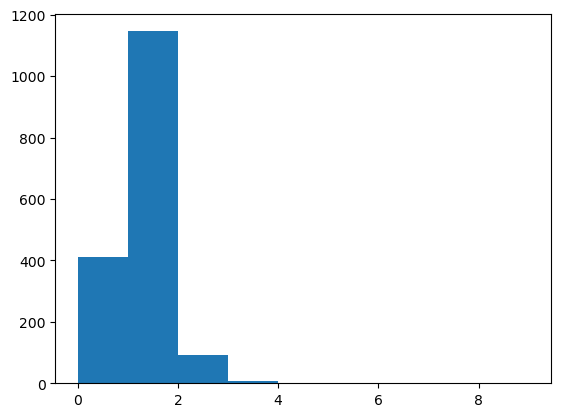

0.5434782608695652
16.552511415525114
24.75845410628019


In [5]:
# Histogram of nuclei count inside membrane
plt.hist(feat_mem.nuclei_count, bins=range(0, 10))
plt.show()

# Percentage of membranes with 3 or more nuclei
print((feat_mem.nuclei_count >= 3).sum() / len(feat_mem) * 100)

# percentage of nuclei assigned to membrane
# number of nan values in membrane_ids / total number of nuclei
print((feat_nu.membrane_id.isna().sum() / len(feat_nu)) * 100)

# percentage of membrane assigned to nuclei
# number of nan values in nuclei_ids / total number of membrane
print((feat_mem.nuclei_ids.isna().sum() / len(feat_mem)) * 100)

In [6]:
feat_mem_3_more = feat_mem[feat_mem.nuclei_count >= 3]

for count, i in enumerate(feat_mem_3_more.index):
    if count > 0:
        break
    centroids = feat_mem_3_more.loc[i, 'centroids'].replace('[', '').replace(']', '').replace(',', ' ').split()
    x, y, z = int(centroids[0]), int(centroids[1]), int(centroids[2])
    
    mem_id = feat_mem_3_more.loc[i, 'original_labels']
    nu_ids = feat_mem_3_more.loc[i, 'nuclei_ids'].split(', ')
    
    print(x, y, z, mem_id, nu_ids)
    
    mask_mem = membrane[x-25:x+25, y-25:y+25, z-10:z+10]
    mask_mem = np.where(mask_mem == mem_id, 255, 0)
    
    mask_nuclei = nuclei[x-25:x+25, y-25:y+25, z-10:z+10]
    for nu_id in nu_ids:
        mask_nuclei += np.where(mask_nuclei == int(float(nu_id)), 255, 0)
        
    for z in range(mask_mem.shape[-1]):
        cv2.imshow(
            'membrane and nuclei',
            np.hstack([
                mask_mem[..., z].astype(np.uint8), 
                mask_nuclei[..., z].astype(np.uint8),
                cv2.bitwise_and(mask_mem[..., z].astype(np.uint8), mask_nuclei[..., z].astype(np.uint8))
            ])
        )
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    

118 517 185 1358.0 ['4278.0', '4497.0', '4025.0']


In [46]:

# for i in range(len(feat_mem)):
#     # if i > 10:
#     #     break
#     # Get props
#     centroids = feat_mem.loc[i, 'centroids']
#     centroids = centroids.replace('[', '').replace(']', '').replace(',', ' ').split()
#     x, y, z = int(centroids[0]), int(centroids[1]), int(centroids[2])
# 
#     cell_id = feat_mem.loc[i, 'original_labels']
#     
#     if cell_id != 7367:
#         continue
#     
#     print(cell_id, x, y, z)
#     
#     # Crop 3d membrane around the centroid | Dilate | same for nuclei
#     mem_crop = membrane[x-25:x+25, y-25:y+25, z-10:z+10]
#     mem_crop = np.where(mem_crop == cell_id, 255, 0)
#     mem_crop = np.swapaxes(np.swapaxes([
#         cv2.dilate(mem_crop[..., z].astype(np.uint8), np.ones((3, 3)), iterations=1)
#         for z in range(mem_crop.shape[-1])
#     ], 0, 1), 1, 2)
#     
#     # Remove empty z-slices
#     non_empty_slices = [z for z in range(mem_crop.shape[-1]) if np.any(mem_crop[..., z])]
#     mem_crop = mem_crop[..., non_empty_slices]
#     
#     # Nuclei
#     nu_crop = nuclei[x-25:x+25, y-25:y+25, z-10:z+10]
#     nu_crop = np.where(mem_crop == 0, 0, nu_crop)
#     nu_crop = nu_crop[..., non_empty_slices]
#     
#     nu_in_mem_pix_count = [
#         np.sum(nu_crop == u)
#         for u in np.unique(nu_crop)
#         if u != 0
#     ]
#     print(np.unique(nu_crop)[1:])
#     print(nu_in_mem_pix_count)
#     
#     # Intersection | mask | sum
#     intersection = np.logical_and(mem_crop, nu_crop)
#     inter_sum = np.sum(intersection)
#     
#     # Union | mask | sum
#     union = np.logical_or(mem_crop, nu_crop)
#     union_sum = np.sum(union)
#     
#     print(inter_sum, union_sum)
#     
#     # for j in range(mem_crop.shape[-1]):
#     #     cv2.imshow('mem', np.hstack([
#     #         mem_crop[..., j].astype(np.uint8), 
#     #         nu_crop[..., j].astype(np.uint8)
#     #     ]))
#     #     cv2.waitKey(0)
#     #     cv2.destroyAllWindows()
#     
#     # if 0 sums -> no nuclei inside membrane
#     if inter_sum == 0:
#         continue
#         
#     # Overlap percentage
#     overlap = inter_sum / union_sum
#     print(cell_id, x, y, z)
#     print(inter_sum, union_sum)
#     print(overlap)
#     
#     

In [40]:
# feat_nu = pd.DataFrame(
#     columns=['x', 'y', 'z', 'volume', 'label', 'cell_in_props'],
#     data=[
#         [int(x), int(y), int(z), vol, label] 
#         for (x, y, z), vol, label
#         in zip(
#             list(map(
#                 lambda aux: aux.replace('[', '').replace(']', '').replace(',', ' ').split(), 
#                 nuclei.centroids
#             )),
#             nuclei.volumes,
#             nuclei.original_labels
#         )
#     ]
# )
# 
# feat_mem = pd.DataFrame(
#     columns=['x', 'y', 'z', 'volume', 'label', 'cell_in_props'],
#     data=[
#         [int(x), int(y), int(z), vol, label] 
#         for (x, y, z), vol, label
#         in zip(
#             list(map(
#                 lambda aux: aux.replace('[', '').replace(']', '').replace(',', ' ').split(), 
#                 membrane.centroids
#             )),
#             membrane.volumes,
#             membrane.original_labels
#         )
#     ]
# )